In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn import linear_model

In [2]:
# Get training property info

filename = 'Data/train_2016.csv'
trainid_df = pd.read_csv(filename)

# Get property info

filename = 'Data/properties_2016.csv'
properties_df = pd.read_csv(filename)

C:\Users\Matthew\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
# Put respective properties_df info into train_df.

properties_df.set_index('parcelid', inplace = True)
trainid_df.set_index('parcelid', inplace = True)

train_df = trainid_df.join(properties_df)

In [4]:
# Set up the values dataframe that we will be using.

vals_df = train_df[['logerror', 'latitude', 'longitude', 'yearbuilt']]
vals_df = vals_df.dropna()

In [28]:
vals_df['abslogerror'] = np.abs(vals_df.logerror.values)

(3600, 4)


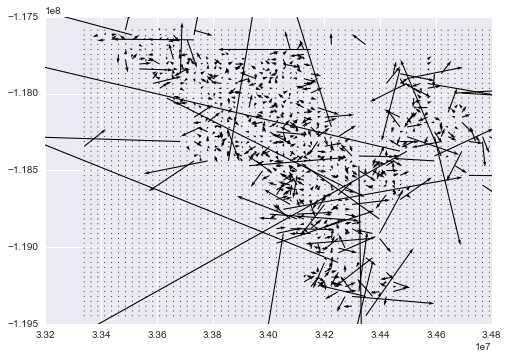

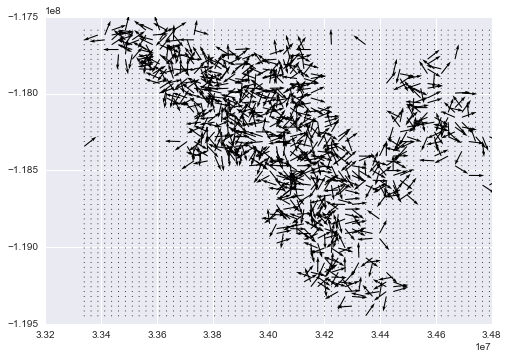

In [11]:
# Find Gradients of Year Built

nbins = 60
linregr = linear_model.LinearRegression()

minlong = np.amin(vals_df.longitude)
maxlong = np.amax(vals_df.longitude)
minlat = np.amin(vals_df.latitude)
maxlat = np.amax(vals_df.latitude)

dlong = (maxlong - minlong) / nbins
dlat = (maxlat - minlat) / nbins

fitinfo = []

for y in np.arange(minlat, maxlat, dlat):
    indicesy = (y < vals_df.latitude.values) & (vals_df.latitude.values < y + dlat)
    for x in np.arange(minlong, maxlong, dlong):
        indices = indicesy & (x < vals_df.longitude.values) & (vals_df.longitude.values < x + dlong)
        x_train = vals_df[['latitude', 'longitude']].values[indices]

        if(len(x_train) > 0):
            y_train = vals_df['yearbuilt'].values[indices]
            y_train = y_train.reshape(-1,1)
        
            linregr.fit(x_train, y_train)
            coeffs = linregr.coef_ 
            coeffs = coeffs.reshape(2)
            
        else:
            
            coeffs = np.array([0.0, 0.0])
        
        xa = np.array([x])
        ya = np.array([y])
        newinfo = np.hstack((ya, xa, coeffs))    
        fitinfo.append(newinfo)
        
fitinfo = np.array(fitinfo)
print(fitinfo.shape)

plotinfo = fitinfo.T
plt.quiver(plotinfo[0], plotinfo[1], plotinfo[2], plotinfo[3])
plt.show()

# Now plot directions
plotinfo = fitinfo
for i in range(len(plotinfo)):
    mag = np.linalg.norm(plotinfo[i][2:4])
    if mag > 0:
        plotinfo[i][2:4] /= mag

plotinfo = plotinfo.T
plt.quiver(plotinfo[0], plotinfo[1], plotinfo[2], plotinfo[3])
plt.show()


In [34]:
# Now use nearest neighbors to find nearest gradients of yearbuilt for points.

k = 8
nbrs = NearestNeighbors(k)
nbrs.fit(fitinfo[:, 0:2])
coords = vals_df[['latitude', 'longitude']].values
nbrdistance, nbrindex = nbrs.kneighbors(coords)

gradients = fitinfo[nbrindex][:, :, 2:4]
print(gradients.shape)
gradients = np.mean(gradients, axis = 1)
print(gradients.shape)
gradmag = np.linalg.norm(gradients, axis = 1)
print(gradmag.shape)
vals_df['gradmag'] = gradmag.T
gradmag

(89519, 8, 2)
(89519, 2)
(89519,)


array([ 0.18983367,  0.18983367,  0.18983367, ...,  0.1718445 ,
        0.38302384,  0.09132675])

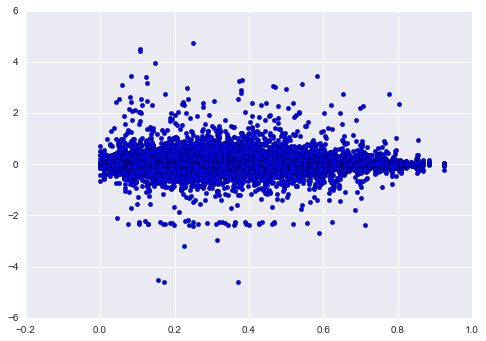

In [35]:
plt.scatter(vals_df.gradmag, vals_df.logerror)
plt.show()

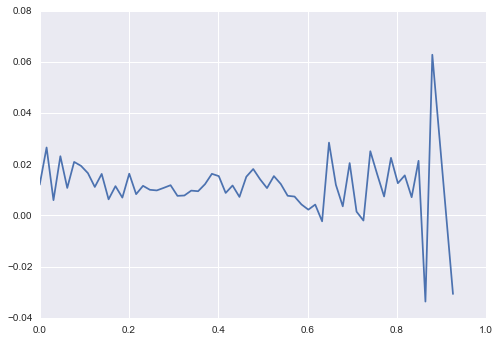

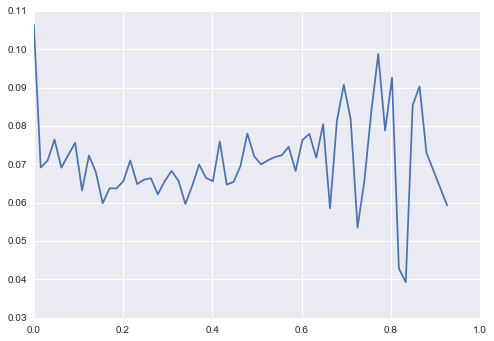

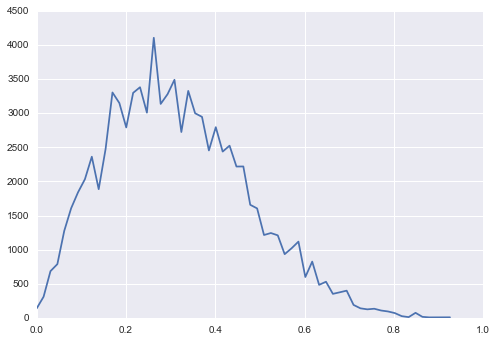

In [36]:
# Bin the gradient magnitude
nbins = 60
bins = vals_df.gradmag.values
minval = np.amin(bins)
maxval = np.amax(bins)
bins = (bins - minval) / (maxval - minval) * nbins
bins = bins.astype(int)
bins = minval + bins * (maxval - minval) / nbins
vals_df['bins'] = bins

grouped_df = vals_df.groupby('bins').mean()
plt.plot(grouped_df.index, grouped_df.logerror)
plt.show()

plt.plot(grouped_df.index, grouped_df.abslogerror)
plt.show()

grouped_df = vals_df.groupby('bins').count()
plt.plot(grouped_df.index, grouped_df.logerror)
plt.show()


In [37]:
# Try linear fit on simply year built and diffusions

linregr = linear_model.LinearRegression()

x_train = vals_df['gradmag'].values
x_train = x_train.reshape(-1,1)
y_train = vals_df['logerror'].values
y_train = y_train.reshape(-1,1)
    
linregr.fit(x_train, y_train)
y_predict = linregr.predict(x_train)
    
predicterror = y_predict.flat - vals_df['logerror'].values
meanerror = np.mean(predicterror)
print('mean error prediction = ', meanerror)
meanabserror = np.mean(np.abs(predicterror))
print('mean abs error predictions = ', meanabserror)

origerror = np.mean(np.abs(vals_df['logerror'].values))
(meanabserror - origerror) / origerror

mean error prediction =  3.33368278264e-18
mean abs error predictions =  0.0679032729878


7.0332368304143196e-05

In [39]:
# Try linear fit on simply year built and diffusions

linregr = linear_model.LinearRegression()

x_train = vals_df[['yearbuilt', 'gradmag']].values
y_train = vals_df['logerror'].values
y_train = y_train.reshape(-1,1)
    
linregr.fit(x_train, y_train)
y_predict = linregr.predict(x_train)
    
predicterror = y_predict.flat - vals_df['logerror'].values
meanerror = np.mean(predicterror)
print('mean error prediction = ', meanerror)
meanabserror = np.mean(np.abs(predicterror))
print('mean abs error predictions = ', meanabserror)

origerror = np.mean(np.abs(vals_df['logerror'].values))
(meanabserror - origerror) / origerror

mean error prediction =  -3.09556258388e-18
mean abs error predictions =  0.0679371116995


0.00056870439251239439